# Problema 2: Datos sintéticos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carga de los datos

In [2]:
x_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_entrenamiento.csv", header=None)
y_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_entrenamiento.csv", header=None)
x_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_validacion.csv", header=None)
y_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_validacion.csv", header=None)

## a. Graficación de los datos


Text(0.5, 1.0, '$x$ vs $y$ on training set')

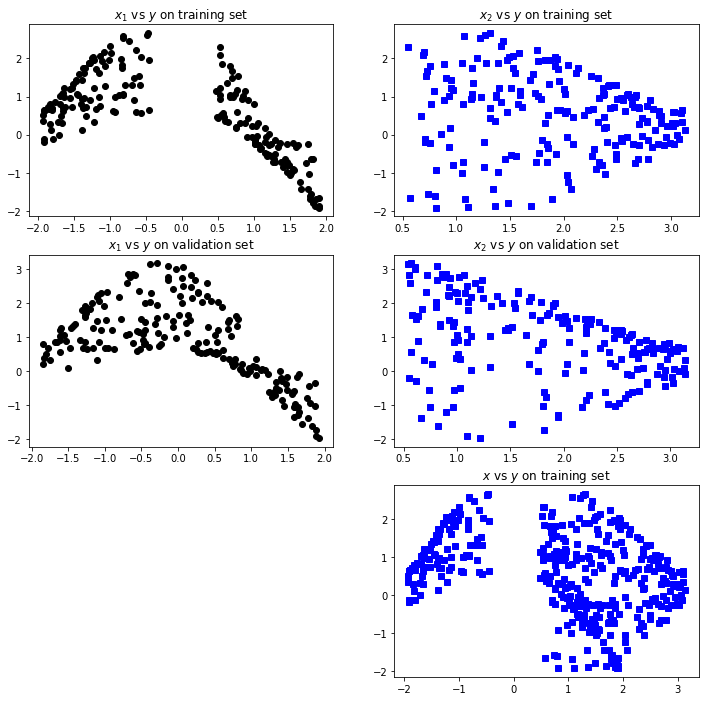

In [3]:
# Graficación de los datos
gs = plt.GridSpec(3,2)
fig = plt.figure(figsize=(12,12))
fig.tight_layout()

# Training data
fig.add_subplot(gs[0,0]).plot(x_train.values[0:,0],y_train.values[0:], 'ko')
plt.title("$x_1$ vs $y$ on training set")
fig.add_subplot(gs[0,1]).plot(x_train.values[0:,1],y_train.values[0:], 'bs')
plt.title("$x_2$ vs $y$ on training set")

fig.add_subplot(gs[1,0]).plot(x_val.values[0:,0],y_val.values[0:],'ko')
plt.title("$x_1$ vs $y$ on validation set")
fig.add_subplot(gs[1,1]).plot(x_val.values[0:,1],y_val.values[0:],'bs')
plt.title("$x_2$ vs $y$ on validation set")

fig.add_subplot(gs[2,1]).plot(x_train.values,y_train.values, 'bs')
plt.title("$x$ vs $y$ on training set")

## b. Regresión lineal 
Modelo $f(x,a) = a_0+a_1x_1+a_2x_2$. Hallar $a = (a_0,a_1,a_2)$ que minimiza la función de error
$$E(a)=\frac{1}{2}\sum _{i=0}^N(y_i-f(x^i,a))^2$$

## Training a linear regression

In [11]:
# Import my implementation of polynomial multiple regression see polynomialReg.py for details
from polynomialReg import *

# Call implementation of multiple polynomial regression with polynomial of degree 1 for a linear fitting
mlinear = polynomial_linreg(x_train.values,y_train.values,1)
mlinear.fit()

# Print coefficients of the fitted line
print(mlinear.a)

[[ 1.08332958]
 [-0.54618495]
 [-0.30062493]]


In [21]:
# Report the squares error for linear fitting on training set
print(mlinear.sqerror(x_train.values,y_train.values))

# Report the squares error for linear fitting on validation set
print(mlinear.sqerror(x_val.values,y_val.values))

7.678865214973421
9.480140975366947


## c) Regression with polynomials

In [14]:
# Find degree between 1 to 50 that ensures best polynomial fitting on validation data

results = np.zeros(50)
for d in range(0,50):
    # Call implementation of multiple polynomial regression with polynomial of degree d
    mpolynom = polynomial_linreg(x_train.values,y_train.values,d + 1)
    mpolynom.fit()
    results[d] = mpolynom.sqerror(x_val.values,y_val.values)

Min Error: 5.108905934652413 for degree  7
5.108905934652413


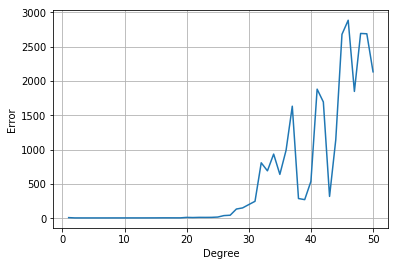

In [26]:
# Minimum error and degree in 1,..., 50 that ensures it
print("Min Error:", np.min(results), "for degree ", np.argmin(results) + 1)

print(results[6])
#xs = [d for d in range(1,51)]

plt.plot(np.arange(1,51), results)
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Degree")
fig.tight_layout()
plt.show()

In [19]:
mbest = polynomial_linreg(x_train.values, y_train.values, 7)
mbest.fit()
print(mbest.a)
print(mbest.sqerror(x_val.values,y_val.values))

[[ 3.28940617e+01]
 [-4.21922226e-01]
 [-1.25538711e+00]
 [-7.11293011e-01]
 [ 4.32737575e-01]
 [ 4.41863376e-01]
 [-7.89263367e-02]
 [-7.18061000e-02]
 [-1.55013254e+02]
 [ 3.19633004e+02]
 [-3.50279821e+02]
 [ 2.20663449e+02]
 [-8.01324141e+01]
 [ 1.55692593e+01]
 [-1.25150297e+00]]
5.108905934652413


In [28]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(x_train.values,y_train.values)
print(linreg.intercept_)
print(linreg.coef_)

# Función suma de errores cuadrados
def skl_sqerrors(x,y):
    s = 0.0
    xl = linreg.predict(x)
    for i in range(0,len(x)):
        s += (xl[i]-y[i][0])**2
    return np.sqrt(s/2)

print("Error on test set with linreg:", skl_sqerrors(x_val.values,y_val.values))

[1.08332958]
[[-0.54618495 -0.30062493]]
Error on training set with linreg: [7.67886521]
Error on test set with linreg: [9.48014098]
